In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
data = pd.read_csv('C:/Users/a5987/Documents/Kurs_project_task/train.csv', sep=',')

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


### Столбец Healthcare_1 наполовину пуст, поэтому от него можно избавиться. Столбец LifeSquare пуст на три четверти, но есть опасение, что попытки заполнить остаток повредят обучению, поэтому его тоже можно удалить.

### Посмотрим, есть ли квартиры, где KitchenSquare больше Square. 

In [53]:
data.loc[data['Square'] < data['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960518
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275


### Можно заменить значения KitchenSquare отношением площади к числу, равному отношению средней площади к средней площади кухни.

### Теперь посмотрим, сколько кухонь имеют нулевую площадь

In [54]:
zero_kitchen = data.loc[data['KitchenSquare'] == 0]
zero_kitchen.shape

(697, 20)

### Исправим их так же, как и предыдущие данные

In [55]:
del(zero_kitchen) # удалим ненужный датасет

### Заменим теперь буквенные данные на численные

In [56]:
data['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

### 99 % данных в столбце неизменны, удаляем

In [57]:
data['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [58]:
data['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Здесь перекос тоже значителен, но удалять не будем

### Теперь посмотрим, сколько квартир находится на этаже выше, чем этажность дома

In [59]:
swapped = data.loc[data['Floor'] > data['HouseFloor']]
swapped.shape

(1825, 20)

In [60]:
del(swapped)

### Функция для очистки данных

In [61]:
def clear_data(df):
    ratio = df['Square'].median()/df['KitchenSquare'].median()
    df.loc[(df['Square'] < df['KitchenSquare']), 'KitchenSquare'] = df['Square']/ratio # кухни с площадями большими, чем у квартиры
    df.loc[(df['KitchenSquare'] == 0), 'KitchenSquare'] = df['Square']/ratio # кухни с нулевыми площадями
    df['Shops_2'] = (df['Shops_2'] == 'A').astype(int) # замена букв на цифры
    df['Ecology_3'] = (df['Ecology_3'] == 'A').astype(int) # замена букв на цифры
    df.loc[(df['HouseFloor'] == 0), 'HouseFloor'] = df['HouseFloor'].median() # заменяем нулевую этажность на среднюю
    df.loc[(df['Floor'] > df['HouseFloor']), 'Floor'] = df['HouseFloor'] # меняем местами этаж и этажность
    df.loc[(df['Floor'] > df['HouseFloor']), 'HouseFloor'] = df['Floor'] # меняем местами этаж и этажность
    df = df.drop(['DistrictId', 'LifeSquare', 'Healthcare_1', 'Ecology_2'], axis=1) # удаление ненужных и малоинформативных столбцов
    return df

### Посмотрим, какую в среднем площадь имеют квартиры с разным числом комнат

In [62]:
area_avg = data.groupby('Rooms', as_index=False)[['Square']].median()
area_avg

,Rooms,Square
0,0.0,65.487474
1,1.0,40.406590
2,2.0,55.841812
3,3.0,77.413643
4,4.0,98.668054
5,5.0,116.084861
6,6.0,59.414334
7,10.0,59.964120
8,19.0,42.006046


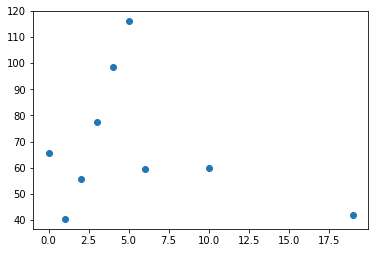

In [63]:
plt.scatter(area_avg['Rooms'], area_avg['Square'])

### Видно, что, за исключением некоторых квартир, в среднем прослеживается прямая зависимость между количеством комнат и площадью. Воспользуемся этим:

In [64]:
del(area_avg)

### Функция для приведения в порядок числа комнат

In [65]:
def rooms(df):
    rba = df.groupby('Rooms', as_index=False)[['Square']].median()
    delta_y = np.array(rba.loc[rba['Rooms'] == 3, 'Square'])[0] - np.array(rba.loc[rba['Rooms'] == 2, 'Square'])[0] # вычисляем угловой коэфф-т воображаемой прямой
    b = np.array(rba.loc[rba['Rooms'] == 1, 'Square'])[0] - delta_y # вычисляем b из уравнения y = kx + b
    df.loc[(df['Rooms'] > 3*((df['Square'] - b)/delta_y).round()) | (df['Rooms'] == 0), 'Rooms'] = ((rba['Square'] - b)/delta_y).round() # делаем замену нулевых или слишком выбивающихся значений
    df['Rooms'].fillna((df['Rooms'].median()), inplace=True)
    return df

In [66]:
data = clear_data(data)

In [67]:
data = rooms(data)

In [68]:
target = data['Price']
data = data.drop('Price', axis=1)

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
train, valid, ttrain, tvalid = train_test_split(data, target, test_size=0.3, random_state=50)

In [71]:
from sklearn.metrics import r2_score as r2

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
from sklearn.model_selection import GridSearchCV

In [74]:
parameters = [{'n_estimators': [100, 150, 200],
               'max_depth': np.arange(7, 9), 
               'max_features': np.arange(7, 10)}]

In [75]:
grid = GridSearchCV(estimator=RandomForestRegressor(random_state=100),
                   param_grid=parameters,
                   scoring='r2',
                   cv=5)

In [76]:
grid.fit(train, ttrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [100, 150, 200], 'max_depth': array([7, 8]), 'max_features': array([7, 8, 9])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [77]:
grid.best_params_

{'max_depth': 8, 'max_features': 9, 'n_estimators': 200}

In [78]:
rf = RandomForestRegressor(n_estimators=200, max_depth=8, max_features=9, random_state=100)

In [79]:
rf.fit(train, ttrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=100, verbose=0, warm_start=False)

In [80]:
y_pred_train2 = rf.predict(train)

In [81]:
y_pred2 = rf.predict(valid)

In [82]:
r2(ttrain, y_pred_train2)

0.7787592199172704

In [83]:
r2(tvalid, y_pred2)

0.7219909217703406

In [84]:
test = pd.read_csv('C:/Users/a5987/Documents/Kurs_project_task/test.csv', sep=',')
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [85]:
test_ = clear_data(test)

In [86]:
test_ = rooms(test_)

In [87]:
test_['Price'] = rf.predict(test_)

In [88]:
test_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
Id               5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null float64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_3        5000 non-null int32
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null int32
Price            5000 non-null float64
dtypes: float64(7), int32(2), int64(7)
memory usage: 586.0 KB


In [89]:
test_.loc[:, ['Id', 'Price']].to_csv('C:/Users/a5987/Documents/Kurs_project_task/MAlascarof_predictions.csv', sep=',', index=None)

In [90]:
test_['Price'].median()

197600.5335369918